In [15]:
# Packages

import selfies as sf
import pathlib as Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pyarrow as pa

In [2]:
# Loading df_mofs_v3 (standardized) via parquet to retain types

df_mofs_v3 = pd.read_parquet(r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\MOF_processed data\df_mofs_v3.parquet")

In [3]:
df_mofs_v3.columns

Index(['MOFid', 'metal', 'linker', 'logKH_CO2', 'pure_uptake_CO2_298.00_15000',
       'pure_uptake_methane_298.00_6500000', 'LCD', 'PLD', 'LFPD', 'cm3_g',
       'ASA_m2_cm3', 'ASA_m2_g', 'NASA_m2_cm3', 'NASA_m2_g', 'AV_VF',
       'AV_cm3_g', 'NAV_cm3_g', 'All_Metals', 'Has_OMS', 'Open_Metal_Sites',
       'metal_ids', 'metal_oms_flags', 'linker_ids'],
      dtype='object')

In [10]:
# Help functions

def stratified_split(df, target_col='logKH_CO2', test_size=0.1, val_size=0.1, random_state=42):
    """
    타겟 분포를 고려해서 데이터 나누기
    
    df: 데이터프레임
    target_col: 중요한 타겟 컬럼 (이 값의 분포가 골고루 나뉨)
    test_size: 테스트 비율 (0.1 = 10%)
    val_size: 검증 비율 (0.1 = 10%)
    """
    # 타겟을 5개 구간으로 나눔 (낮음, 중하, 중간, 중상, 높음)
    df = df.copy()
    df['_group'] = pd.qcut(df[target_col], q=5, labels=False, duplicates='drop')
    
    # 1단계: Train+Val vs Test 분리
    train_val, test = train_test_split(
        df, 
        test_size=test_size,
        stratify=df['_group'],  # 각 구간에서 골고루 뽑기
        random_state=random_state
    )
    
    # 2단계: Train vs Val 분리
    val_ratio = val_size / (1 - test_size)  # 남은 데이터에서 val 비율 계산
    train, val = train_test_split(
        train_val,
        test_size=val_ratio,
        stratify=train_val['_group'],
        random_state=random_state
    )
    
    # 임시로 만든 '_group' 컬럼 삭제
    train = train.drop(columns=['_group'])
    val = val.drop(columns=['_group'])
    test = test.drop(columns=['_group'])
    
    # 결과 출력
    print(f"Train: {len(train)} ({len(train)/len(df)*100:.1f}%)")
    print(f"Val:   {len(val)} ({len(val)/len(df)*100:.1f}%)")
    print(f"Test:  {len(test)} ({len(test)/len(df)*100:.1f}%)")
    print(f"\n{target_col} 평균:")
    print(f"Train: {train[target_col].mean():.3f}")
    print(f"Val:   {val[target_col].mean():.3f}")
    print(f"Test:  {test[target_col].mean():.3f}")
    
    return train, val, test

def plot_split_distributions(train_df, val_df, test_df, columns):
    """Train/Val/Test 분포 시각적 비교"""
    fig, axes = plt.subplots(1, len(columns), figsize=(5*len(columns), 4))
    if len(columns) == 1:
        axes = [axes]
    
    for i, col in enumerate(columns):
        axes[i].hist(train_df[col], alpha=0.5, label='Train', bins=30, density=True)
        axes[i].hist(val_df[col], alpha=0.5, label='Val', bins=30, density=True)
        axes[i].hist(test_df[col], alpha=0.5, label='Test', bins=30, density=True)
        axes[i].set_title(col)
        axes[i].legend()
        axes[i].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()




In [11]:

# Train / Val / Test dataset split
train_df, val_df, test_df = stratified_split(
    df_mofs_v3, 
    target_col='logKH_CO2',  # 가장 중요한 타겟 하나만
    test_size=0.1,           # 10% 테스트
    val_size=0.1             # 10% 검증
)

# Saving Train / Val / Test dataset in parquet forms.

train_df.to_parquet(r'C:\Users\dalja\OneDrive\Desktop\APS360 Project\MOF_processed data\train_df.parquet', index=False)
val_df.to_parquet(r'C:\Users\dalja\OneDrive\Desktop\APS360 Project\MOF_processed data\val_df.parquet', index=False)
test_df.to_parquet(r'C:\Users\dalja\OneDrive\Desktop\APS360 Project\MOF_processed data\test_df.parquet', index=False)

Train: 2665 (80.0%)
Val:   334 (10.0%)
Test:  334 (10.0%)

logKH_CO2 평균:
Train: -0.001
Val:   -0.006
Test:  0.016


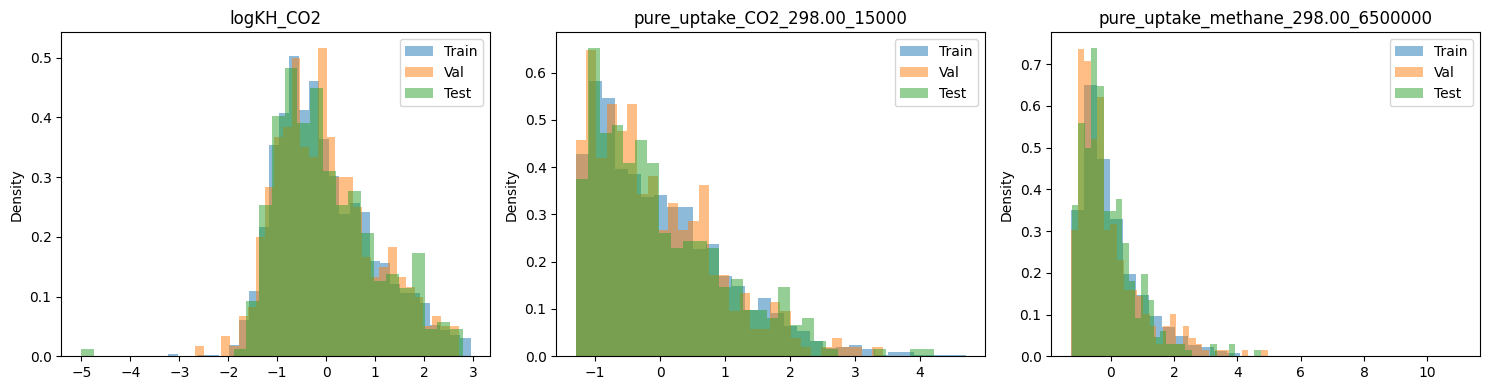

In [12]:
# Distribution of Train / Val / Test datasets; looking for similarity

plot_split_distributions(
    train_df, 
    val_df, 
    test_df, 
    columns=['logKH_CO2', 'pure_uptake_CO2_298.00_15000',
       'pure_uptake_methane_298.00_6500000']
)

In [7]:
class MOFDataset(Dataset):
    def __init__(self, df, geometry_cols, target_cols):
        self.df = df
        self.geometry_cols = geometry_cols
        self.target_cols = target_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
            row = self.df.iloc[idx]
            
            geometry = torch.tensor(
                row[self.geometry_cols].values.astype(np.float32), 
                dtype=torch.float32
            )
            
            metal_ids = torch.tensor(
                row['metal_ids'], 
                dtype=torch.long
            )
            
            metal_oms = torch.tensor(
                row['metal_oms_flags'], 
                dtype=torch.float32
            )
            
            linker_ids = torch.tensor(
                row['linker_ids'], 
                dtype=torch.long
            )
            
            targets = torch.tensor(
                row[self.target_cols].values.astype(np.float32), 
                dtype=torch.float32
            )
            
            return {
                'geometry': geometry,
                'metal_ids': metal_ids,
                'metal_oms': metal_oms,
                'linker_ids': linker_ids,
                'targets': targets
            }

In [8]:
geometry_cols = ['LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g', 
                 'NASA_m2_cm3', 'NASA_m2_g', 'AV_VF', 'AV_cm3_g', 'NAV_cm3_g']

target_cols = ['logKH_CO2', 'pure_uptake_CO2_298.00_15000', 
               'pure_uptake_methane_298.00_6500000']

# 재생성
train_dataset = MOFDataset(train_df, geometry_cols, target_cols)
val_dataset = MOFDataset(val_df, geometry_cols, target_cols)
test_dataset = MOFDataset(test_df, geometry_cols, target_cols)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 84
Val batches: 11
Test batches: 11


In [9]:
import joblib

metal_vocab = joblib.load('metal_vocabulary.pkl')
print(f"Metal vocab type: {type(metal_vocab)}")
print(f"Metal vocab: {metal_vocab}")

linker_vocab = joblib.load('linker_vocabulary.pkl')
print(f"\nLinker data type: {type(linker_vocab)}")
print(f"Metal vocab: {linker_vocab}")

Metal vocab type: <class 'dict'>
Metal vocab: {'[nop]': 0, 'Ag': 1, 'Al': 2, 'Au': 3, 'Ba': 4, 'Be': 5, 'Bi': 6, 'Ca': 7, 'Cd': 8, 'Ce': 9, 'Co': 10, 'Cr': 11, 'Cs': 12, 'Cu': 13, 'Dy': 14, 'Er': 15, 'Eu': 16, 'Fe': 17, 'Ga': 18, 'Gd': 19, 'Hf': 20, 'Ho': 21, 'In': 22, 'Ir': 23, 'K': 24, 'La': 25, 'Li': 26, 'Lu': 27, 'Mg': 28, 'Mn': 29, 'Mo': 30, 'Na': 31, 'Nb': 32, 'Nd': 33, 'Ni': 34, 'Pb': 35, 'Pd': 36, 'Pr': 37, 'Pt': 38, 'Rb': 39, 'Re': 40, 'Rh': 41, 'Ru': 42, 'Sm': 43, 'Sn': 44, 'Sr': 45, 'Tb': 46, 'Th': 47, 'Tm': 48, 'U': 49, 'V': 50, 'W': 51, 'Y': 52, 'Yb': 53, 'Zn': 54}

Linker data type: <class 'dict'>
Metal vocab: {'[nop]': 0, '[#Branch1]': 1, '[#Branch2]': 2, '[#CH0]': 3, '[#C]': 4, '[#N]': 5, '[/-Ring1]': 6, '[/-Ring2]': 7, '[/Br]': 8, '[/C@@H1]': 9, '[/C@@]': 10, '[/C@H1]': 11, '[/C@]': 12, '[/CH0]': 13, '[/CH1]': 14, '[/C]': 15, '[/NH0]': 16, '[/NH1]': 17, '[/N]': 18, '[/S]': 19, '[=Branch1]': 20, '[=Branch2]': 21, '[=CH0]': 22, '[=CH1]': 23, '[=C]': 24, '[=N+1]': 25, '[=

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
class SimpleBaselineModel(nn.Module):
    """
    간단한 baseline: 각 modality를 MLP로 인코딩 → concat → predict
    
    구조:
    Geometry → MLP → embedding
    Metal → Embedding → MLP → embedding  
    Linker → Embedding → MLP → embedding
    → Concat → MLP → 3 outputs
    """
    def __init__(self, 
                 n_geometry=11,
                 metal_vocab_size=55,
                 linker_vocab_size=86,
                 max_metals=5,
                 max_linker_len=198,
                 hidden_dim=128):
        super().__init__()
        
        # 1. Geometry encoder (MLP)
        self.geometry_encoder = nn.Sequential(
            nn.Linear(n_geometry, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # 2. Metal encoder
        self.metal_embedding = nn.Embedding(metal_vocab_size, hidden_dim)
        self.metal_encoder = nn.Sequential(
            nn.Linear(max_metals * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # 3. Linker encoder
        self.linker_embedding = nn.Embedding(linker_vocab_size, hidden_dim)
        self.linker_encoder = nn.Sequential(
            nn.Linear(max_linker_len * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # 4. Fusion & prediction
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, 3)  # 3 targets
        )
    
    def forward(self, geometry, metal_ids, linker_ids):
        # Encode geometry
        geo_emb = self.geometry_encoder(geometry)  # (batch, hidden_dim)
        
        # Encode metals
        metal_emb = self.metal_embedding(metal_ids)  # (batch, max_metals, hidden_dim)
        metal_emb = metal_emb.view(metal_emb.size(0), -1)  # Flatten
        metal_emb = self.metal_encoder(metal_emb)  # (batch, hidden_dim)
        
        # Encode linker
        linker_emb = self.linker_embedding(linker_ids)  # (batch, max_linker_len, hidden_dim)
        linker_emb = linker_emb.view(linker_emb.size(0), -1)  # Flatten
        linker_emb = self.linker_encoder(linker_emb)  # (batch, hidden_dim)
        
        # Concatenate all
        combined = torch.cat([geo_emb, metal_emb, linker_emb], dim=1)  # (batch, hidden_dim*3)
        
        # Predict
        output = self.predictor(combined)  # (batch, 3)
        return output


# 사용
model = SimpleBaselineModel(
    n_geometry=11,
    metal_vocab_size=55,
    linker_vocab_size=86,
    max_metals=5,
    max_linker_len=198,
    hidden_dim=128
)

In [45]:
print(model)

SimpleBaselineModel(
  (geometry_encoder): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (metal_embedding): Embedding(55, 128)
  (metal_encoder): Sequential(
    (0): Linear(in_features=640, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (linker_embedding): Embedding(86, 128)
  (linker_encoder): Sequential(
    (0): Linear(in_features=25344, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (predictor): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)


In [46]:
from sklearn.metrics import mean_squared_error, r2_score

def train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-4, device='cuda'):
    
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # 기록용
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_r2': []
    }
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        
        for train_batch in train_loader:            
            # Data to device
            geometry = train_batch['geometry'].to(device)
            metal_ids = train_batch['metal_ids'].to(device)
            linker_ids = train_batch['linker_ids'].to(device)
            targets = train_batch['targets'].to(device)

            outputs = model(geometry,metal_ids,linker_ids)
            
            loss = criterion(outputs, targets)
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)

        # Validating
        model.eval()
        val_loss = 0
        val_targets = []
        val_preds = []

        with torch.no_grad():
            for val_batch in val_loader:
            # Data to device
                geometry = val_batch['geometry'].to(device)
                metal_ids = val_batch['metal_ids'].to(device)
                linker_ids = val_batch['linker_ids'].to(device)
                targets = val_batch['targets'].to(device)


                outputs = model(geometry,metal_ids,linker_ids)
                val_preds.append(outputs.cpu().numpy())
                val_targets.append(targets.cpu().numpy())
                
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        
        avg_val_loss = val_loss / len(val_loader)

        val_preds = np.concatenate(val_preds, axis = 0)
        val_targets = np.concatenate(val_targets, axis=0)
        r2 = r2_score(val_preds, val_targets)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_r2'].append(r2)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}, "
                  f"Val R²: {r2:.4f}")

    return history

def plot_training_history(history):
    """학습 곡선 시각화"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    
    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].set_title('Training & Validation Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # R²
    axes[1].plot(history['val_r2'], color='green')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('R²')
    axes[1].set_title('Validation R²')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, target_names = ['logKH_CO2', 'pure_uptake_CO2_298.00_15000', 
               'pure_uptake_methane_298.00_6500000'], device='cuda'):
    model.eval()
    test_preds = []
    test_targets = []

    with torch.no_grad():
            for test_batch in test_loader:
            # Data to device
                geometry = test_batch['geometry'].to(device)
                metal_ids = test_batch['metal_ids'].to(device)
                linker_ids = test_batch['linker_ids'].to(device)
                targets = test_batch['targets'].to(device)

                outputs = model(geometry,metal_ids,linker_ids)
                test_preds.append(outputs.cpu().numpy())
                test_targets.append(targets.cpu().numpy())

    test_preds = np.concatenate(test_preds, axis=0)
    test_targets = np.concatenate(test_targets, axis=0)

    for i, name in enumerate(target_names):
        rmse = np.sqrt(mean_squared_error(test_targets[:, i], test_preds[:, i]))
        r2 = r2_score(test_preds[:, i], test_targets[:, i])
        
        print(f"\n{name}:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R²:   {r2:.4f}")
    
    return test_preds, test_targets

def plot_regression_scatter(all_targets, all_preds, target_names = ['logKH_CO2', 'pure_uptake_CO2_298.00_15000', 
               'pure_uptake_methane_298.00_6500000'], suptitle=None):
    """
    예측 vs 실제 scatter plot + 대각선 + R² 표시

    all_targets: np.array, shape (N, n_targets)
    all_preds:   np.array, shape (N, n_targets)
    target_names: 리스트, 예) ['logKH_CO2', 'pure_uptake_CO2', 'pure_uptake_CH4']
    """
    n_targets = all_targets.shape[1]
    fig, axes = plt.subplots(1, n_targets, figsize=(5 * n_targets, 4))

    if n_targets == 1:
        axes = [axes]

    for i, name in enumerate(target_names):
        y_true = all_targets[:, i]
        y_pred = all_preds[:, i]

        r2   = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        ax = axes[i]
        ax.scatter(y_true, y_pred, alpha=0.5)

        # 대각선 y=x
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')
        ax.set_title(f"{name}\nR²={r2:.3f}, RMSE={rmse:.3f}")
        ax.grid(alpha=0.3)

    if suptitle is not None:
        fig.suptitle(suptitle)

    plt.tight_layout()
    plt.show()   


In [40]:
history = train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-4, device='cuda')

Epoch 5/50 - Train Loss: 0.3424, Val Loss: 0.3658, Val R²: 0.2746
Epoch 10/50 - Train Loss: 0.2907, Val Loss: 0.3144, Val R²: 0.4455
Epoch 15/50 - Train Loss: 0.2398, Val Loss: 0.3868, Val R²: 0.4535
Epoch 20/50 - Train Loss: 0.2106, Val Loss: 0.3326, Val R²: 0.5105
Epoch 25/50 - Train Loss: 0.1907, Val Loss: 0.3230, Val R²: 0.3958
Epoch 30/50 - Train Loss: 0.1630, Val Loss: 0.3415, Val R²: 0.4326
Epoch 35/50 - Train Loss: 0.1476, Val Loss: 0.3834, Val R²: 0.5060
Epoch 40/50 - Train Loss: 0.1326, Val Loss: 0.3605, Val R²: 0.4734
Epoch 45/50 - Train Loss: 0.1208, Val Loss: 0.3667, Val R²: 0.4567
Epoch 50/50 - Train Loss: 0.1066, Val Loss: 0.3713, Val R²: 0.4917


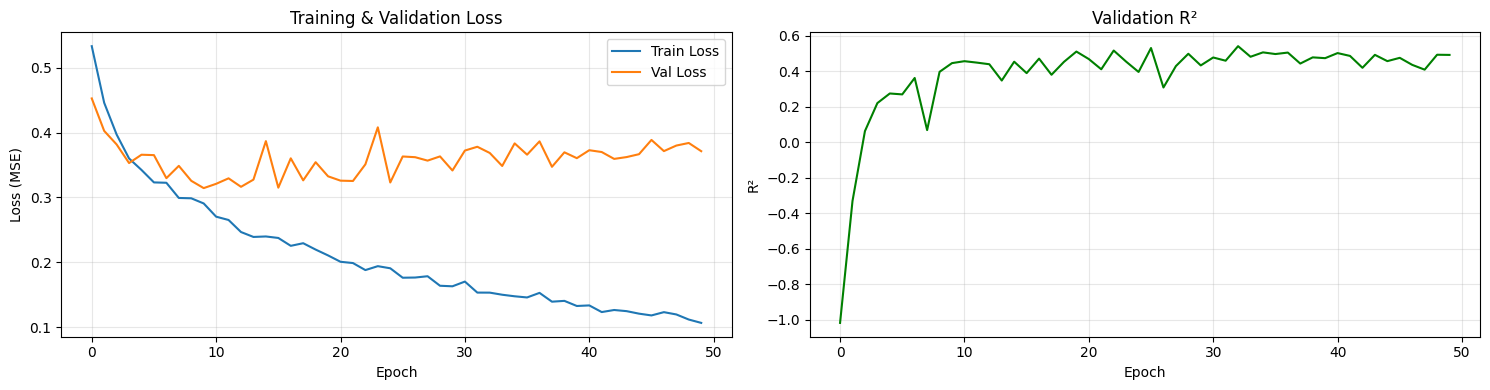

In [42]:
plot_training_history(history)


logKH_CO2:
  RMSE: 0.7753
  R²:   0.2980

pure_uptake_CO2_298.00_15000:
  RMSE: 0.7998
  R²:   0.1692

pure_uptake_methane_298.00_6500000:
  RMSE: 0.1860
  R²:   0.9513


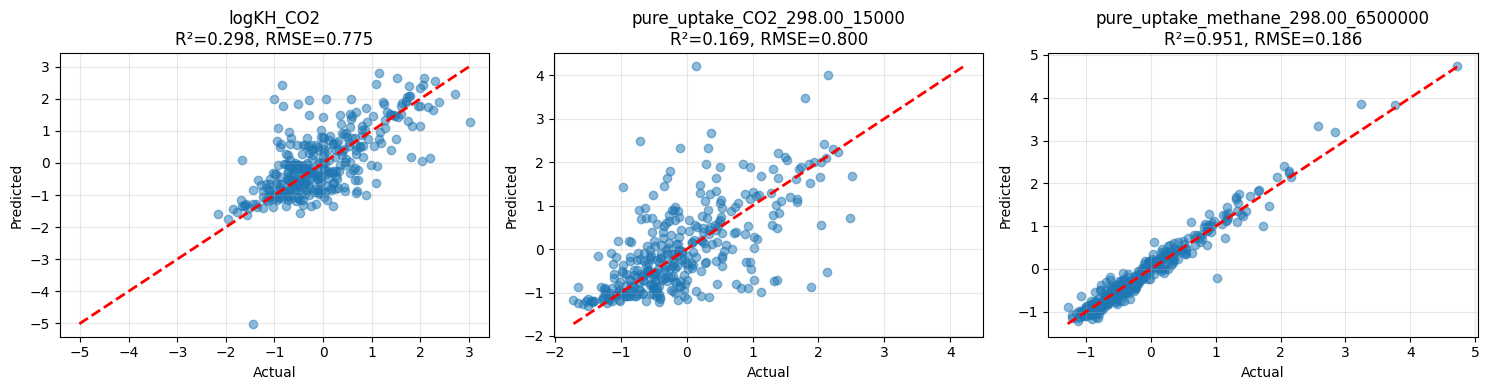

In [47]:
test_result = evaluate_model(model, test_loader, target_names = ['logKH_CO2', 'pure_uptake_CO2_298.00_15000', 
               'pure_uptake_methane_298.00_6500000'], device='cuda')
plot_regression_scatter(*test_result, target_names = ['logKH_CO2', 'pure_uptake_CO2_298.00_15000', 
               'pure_uptake_methane_298.00_6500000'])